full-logo.svg
# **Scout** - Football Talent Discovery for Saudi Arabia



In [ ]:
!pip install ultralytics opencv-python pandas numpy matplotlib scipy

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from collections import defaultdict, deque
import time
from scipy.spatial import distance

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
try:
    from ultralytics import YOLO
except ImportError:
    print("Installing ultralytics...")
    import pip
    pip.main(['install', 'ultralytics'])
    from ultralytics import YOLO

In [ ]:
class SoccerAnalyzer:
    def __init__(self, model_path='yolov8s.pt', confidence=0.3, distance_threshold=50):
        """
        Initialize the soccer analysis pipeline

        Args:
            model_path: Path to YOLOv8 model (pretrained or custom)
            confidence: Detection confidence threshold
            distance_threshold: Max distance for tracking the same object
        """
        self.model = YOLO(model_path)
        self.confidence = confidence
        self.distance_threshold = distance_threshold

        # Classes we're interested in from COCO dataset
        self.target_classes = {
            0: 'person',    # Players
            32: 'sports ball'  # Ball
        }

        # For tracking
        self.trackers = {}
        self.next_id = 0

        # For speed calculation
        self.prev_positions = {}
        self.speeds = defaultdict(list)
        self.position_history = defaultdict(lambda: deque(maxlen=30))  # Store last 30 positions
        self.pixels_per_meter = 50  # This needs calibration

        # For stats
        self.stats = []

    def detect_objects(self, frame):
        """Detect players and ball in a frame"""
        results = self.model(frame, verbose=False, conf=self.confidence, classes=[0, 32])
        detections = []

        if len(results) > 0 and hasattr(results[0], 'boxes') and hasattr(results[0].boxes, 'data'):
            for box_data in results[0].boxes.data:
                x1, y1, x2, y2, conf, class_id = box_data.cpu().numpy()
                class_id = int(class_id)

                if class_id in self.target_classes:
                    # Center point of the bounding box
                    cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)
                    detections.append({
                        'center': (cx, cy),
                        'bbox': (int(x1), int(y1), int(x2), int(y2)),
                        'confidence': float(conf),
                        'class_id': class_id,
                        'class_name': self.target_classes[class_id]
                    })

        return detections

    def update_trackers(self, detections, frame_idx, timestamp):
        """Update trackers with new detections"""
        # If no existing trackers, initialize with first detections
        if not self.trackers:
            for det in detections:
                self.trackers[self.next_id] = {
                    'class_id': det['class_id'],
                    'class_name': det['class_name'],
                    'last_position': det['center'],
                    'last_bbox': det['bbox'],
                    'last_seen': frame_idx
                }
                self.position_history[self.next_id].append((det['center'], timestamp))
                self.next_id += 1
            return

        # Match detections to existing trackers
        detection_matched = [False] * len(detections)

        # For each tracker, find the closest detection
        for tracker_id in list(self.trackers.keys()):
            tracker = self.trackers[tracker_id]

            if frame_idx - tracker['last_seen'] > 30:  # Remove if not seen for 30 frames
                del self.trackers[tracker_id]
                continue

            best_match_idx = -1
            best_distance = float('inf')

            for i, det in enumerate(detections):
                if detection_matched[i]:
                    continue

                # Only match same class objects
                if det['class_id'] != tracker['class_id']:
                    continue

                # Calculate distance between detection and tracker
                d = distance.euclidean(det['center'], tracker['last_position'])

                if d < self.distance_threshold and d < best_distance:
                    best_distance = d
                    best_match_idx = i

            # Update tracker with matched detection
            if best_match_idx >= 0:
                detection_matched[best_match_idx] = True
                matched_det = detections[best_match_idx]

                # Update tracker
                tracker['last_position'] = matched_det['center']
                tracker['last_bbox'] = matched_det['bbox']
                tracker['last_seen'] = frame_idx

                # Store position for speed calculation
                self.position_history[tracker_id].append((matched_det['center'], timestamp))

        # Create new trackers for unmatched detections
        for i, det in enumerate(detections):
            if not detection_matched[i]:
                self.trackers[self.next_id] = {
                    'class_id': det['class_id'],
                    'class_name': det['class_name'],
                    'last_position': det['center'],
                    'last_bbox': det['bbox'],
                    'last_seen': frame_idx
                }
                self.position_history[self.next_id].append((det['center'], timestamp))
                self.next_id += 1

    def calculate_speeds(self, fps):
        """Calculate speed for all tracked objects"""
        speeds = {}

        for track_id, positions in self.position_history.items():
            if len(positions) < 2:
                continue

            # Get the last two positions
            (pos1, time1), (pos2, time2) = positions[-2], positions[-1]

            # Calculate distance in pixels
            dist_pixels = distance.euclidean(pos1, pos2)

            # Time difference in seconds
            time_diff = time2 - time1

            if time_diff > 0:
                # Convert pixels to meters (needs calibration)
                dist_meters = dist_pixels / self.pixels_per_meter

                # Calculate speed in meters per second
                speed_mps = dist_meters / time_diff

                # Convert to km/h
                speed_kph = speed_mps * 3.6

                speeds[track_id] = round(speed_kph, 2)

                # Store in the stats dataframe
                self.stats.append({
                    'timestamp': time2,
                    'id': track_id,
                    'class': self.trackers[track_id]['class_name'],
                    'x': pos2[0],
                    'y': pos2[1],
                    'speed_kph': speed_kph
                })

        return speeds

    def visualize_frame(self, frame, frame_idx, speeds):
        """Draw bounding boxes, IDs, and speed on the frame"""
        output = frame.copy()

        for track_id, tracker in self.trackers.items():
            if frame_idx - tracker['last_seen'] > 5:
                continue  # Skip if not seen recently

            x1, y1, x2, y2 = tracker['last_bbox']

            # Different colors for players and ball
            if tracker['class_id'] == 0:  # Player
                color = (0, 255, 0)  # Green
            else:  # Ball
                color = (0, 0, 255)  # Red

            # Draw bounding box
            cv2.rectangle(output, (x1, y1), (x2, y2), color, 2)

            # Draw ID and class
            label = f"ID:{track_id} {tracker['class_name']}"
            if track_id in speeds:
                label += f" {speeds[track_id]} km/h"

            cv2.putText(output, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # Draw trajectory
            positions = self.position_history[track_id]
            points = [pos[0] for pos in positions]
            if len(points) >= 2:
                for i in range(1, len(points)):
                    cv2.line(output, points[i-1], points[i], color, 2)

        return output

    def process_video(self, video_path, output_path=None, show_video=True):
        """Process entire video and generate stats"""
        cap = cv2.VideoCapture(video_path)

        # Check if video opened successfully
        if not cap.isOpened():
            print(f"Error: Could not open video source {video_path}")
            return pd.DataFrame()  # Return empty DataFrame

        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"Video loaded: {width}x{height} at {fps} FPS, {total_frames} frames")

        # Set up video writer if output path is provided
        writer = None
        if output_path:
            try:
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
                if not writer.isOpened():
                    print(f"Warning: Could not create output video {output_path}")
                    writer = None
            except Exception as e:
                print(f"Error creating video writer: {e}")
                writer = None

        frame_idx = 0
        processed_frames = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Process every 2nd frame for speed (optional)
            if frame_idx % 2 != 0 and total_frames > 300:
                frame_idx += 1
                continue

            # Current timestamp in seconds
            timestamp = frame_idx / fps

            try:
                # Detect objects
                detections = self.detect_objects(frame)

                # Debug info
                if frame_idx % 30 == 0:
                    print(f"Frame {frame_idx}: Detected {len(detections)} objects")
                    for d in detections:
                        print(f"  {d['class_name']} at {d['center']} with conf {d['confidence']:.2f}")

                # Update trackers
                self.update_trackers(detections, frame_idx, timestamp)

                # Calculate speeds
                speeds = self.calculate_speeds(fps)

                # Visualize
                output_frame = self.visualize_frame(frame, frame_idx, speeds)

                # Write to output video
                if writer:
                    writer.write(output_frame)

                # Display
                if show_video:
                    # Resize large frames for display
                    if width > 1280 or height > 720:
                        display_frame = cv2.resize(output_frame, (min(1280, width), min(720, height)))
                    else:
                        display_frame = output_frame

                    cv2.imshow('Soccer Analysis', display_frame)
                    key = cv2.waitKey(1) & 0xFF
                    if key == ord('q'):
                        break
                    elif key == ord('p'):  # Pause/play functionality
                        while True:
                            if cv2.waitKey(100) & 0xFF == ord('p'):
                                break

                processed_frames += 1

            except Exception as e:
                print(f"Error processing frame {frame_idx}: {e}")

            # Progress
            if frame_idx % 30 == 0:
                progress = (frame_idx / total_frames) * 100 if total_frames > 0 else 0
                print(f"Processing: {progress:.1f}% complete", end='\r')

            frame_idx += 1

        # Cleanup
        cap.release()
        if writer:
            writer.release()
        cv2.destroyAllWindows()

        print(f"\nProcessed {processed_frames} frames. Generated {len(self.stats)} data points.")

        # Convert stats to DataFrame
        stats_df = pd.DataFrame(self.stats)
        if not stats_df.empty:
            if output_path:
                stats_file = os.path.splitext(output_path)[0] + '_stats.csv'
                stats_df.to_csv(stats_file, index=False)
                print(f"Statistics saved to {stats_file}")
            return stats_df
        else:
            print("Warning: No statistics were generated from the video")
            return pd.DataFrame()  # Return empty DataFrame

    def generate_heatmaps(self, stats_df=None):
        """Generate heatmaps of player movement"""
        if stats_df is None:
            stats_df = pd.DataFrame(self.stats)

        if stats_df.empty:
            print("No data available for heatmap generation")
            return

        plt.figure(figsize=(10, 8))

        # Plot players
        players_df = stats_df[stats_df['class'] == 'person']
        if not players_df.empty:
            plt.scatter(players_df['x'], players_df['y'], alpha=0.1, color='blue', label='Players')

        # Plot ball
        ball_df = stats_df[stats_df['class'] == 'sports ball']
        if not ball_df.empty:
            plt.scatter(ball_df['x'], ball_df['y'], alpha=0.3, color='red', label='Ball')

        plt.title('Movement Heatmap')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.legend()
        plt.gca().invert_yaxis()  # Invert Y axis to match image coordinates
        plt.savefig('movement_heatmap.png')
        plt.show()

    def generate_speed_chart(self, stats_df=None):
        """Generate a chart of speed over time"""
        if stats_df is None:
            stats_df = pd.DataFrame(self.stats)

        if stats_df.empty:
            print("No data available for speed chart generation")
            return

        plt.figure(figsize=(12, 6))

        # Group by player ID and timestamp
        for object_id, group in stats_df.groupby('id'):
            if len(group) > 5:  # Only plot if we have enough data points
                class_name = group['class'].iloc[0]
                label = f"{class_name} ID:{object_id}"

                plt.plot(group['timestamp'], group['speed_kph'],
                         label=label if object_id < 10 else None)  # Limit legend entries

        plt.title('Speed Over Time')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Speed (km/h)')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.savefig('speed_chart.png')
        plt.show()

    def get_player_stats(self, stats_df=None):
        """Calculate and display overall player statistics"""
        if stats_df is None:
            stats_df = pd.DataFrame(self.stats)

        if stats_df.empty:
            print("No data available for player statistics")
            return

        # Filter only players
        players_df = stats_df[stats_df['class'] == 'person']

        # Group by player ID
        player_stats = {}
        for player_id, group in players_df.groupby('id'):
            # Calculate distance covered
            total_distance = 0
            positions = list(zip(group['x'], group['y']))
            for i in range(1, len(positions)):
                px_distance = distance.euclidean(positions[i-1], positions[i])
                meters = px_distance / self.pixels_per_meter
                total_distance += meters

            # Speed stats
            avg_speed = group['speed_kph'].mean()
            max_speed = group['speed_kph'].max()

            player_stats[player_id] = {
                'distance_covered_m': round(total_distance, 2),
                'avg_speed_kph': round(avg_speed, 2),
                'max_speed_kph': round(max_speed, 2),
                'time_tracked_s': round(group['timestamp'].max() - group['timestamp'].min(), 2)
            }

        return pd.DataFrame.from_dict(player_stats, orient='index')

In [ ]:
def main():
    # Initialize the analyzer
    analyzer = SoccerAnalyzer(model_path='yolov8s.pt', confidence=0.3)

    # Process video
    # Ask user for video path or use webcam if not available
    import os
    video_path = input("Enter the path to your soccer video file: ")

    if not os.path.exists(video_path):
        print(f"File {video_path} not found. Trying to use webcam...")
        video_path = 0  # Use webcam

    output_path = 'analyzed_soccer_match.mp4'

    print(f"Processing video: {video_path}")
    stats_df = analyzer.process_video(video_path, output_path, show_video=True)

    # Check if stats were generated
    if stats_df is None or stats_df.empty:
        print("No statistics were generated. Please check your video input.")
        return

    # Generate visualizations
    print("Generating heatmaps...")
    analyzer.generate_heatmaps(stats_df)

    print("Generating speed charts...")
    analyzer.generate_speed_chart(stats_df)

    # Calculate player stats
    print("Calculating player statistics...")
    player_stats = analyzer.get_player_stats(stats_df)
    print(player_stats)

    # Save player stats if available
    if player_stats is not None and not player_stats.empty:
        player_stats.to_csv('player_stats.csv')
        print("Player stats saved to player_stats.csv")
    else:
        print("No player statistics available to save.")

    print("Analysis complete!")

In [ ]:
def train_custom_model(data_yaml_path, epochs=50, image_size=640):
    # Start with pretrained model
    model = YOLO('yolov8s.pt')

    # Train the model
    results = model.train(
        data=data_yaml_path,
        epochs=epochs,
        imgsz=image_size,
        batch=16,
        save=True
    )

    # Validate the model
    results = model.val()

    print(f"Training complete. Model saved to {os.path.join(model.save_dir, 'weights/best.pt')}")

    return os.path.join(model.save_dir, 'weights/best.pt')

Enter the path to your soccer video file: /content/Match_video.mp4
Processing video: /content/Match_video.mp4
Video loaded: 1280x720 at 25.0 FPS, 152 frames
Frame 0: Detected 5 objects
  person at (309, 458) with conf 0.93
  person at (1189, 468) with conf 0.92
  person at (195, 377) with conf 0.91
  person at (907, 240) with conf 0.90
  person at (990, 257) with conf 0.80
Error processing frame 0: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow

Error processing frame 1: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow

Error processing frame 2: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/noteboo

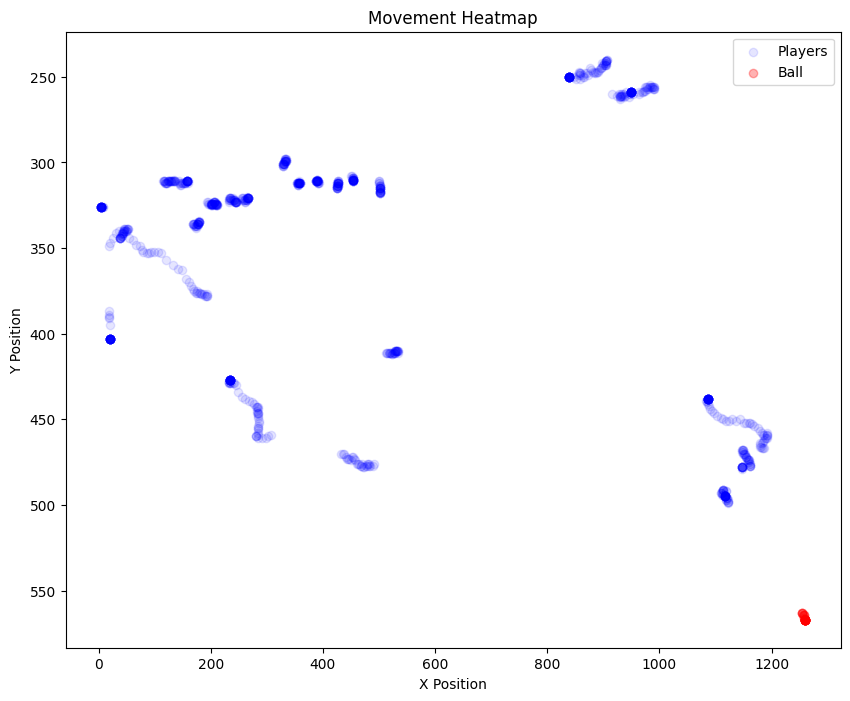

Generating speed charts...


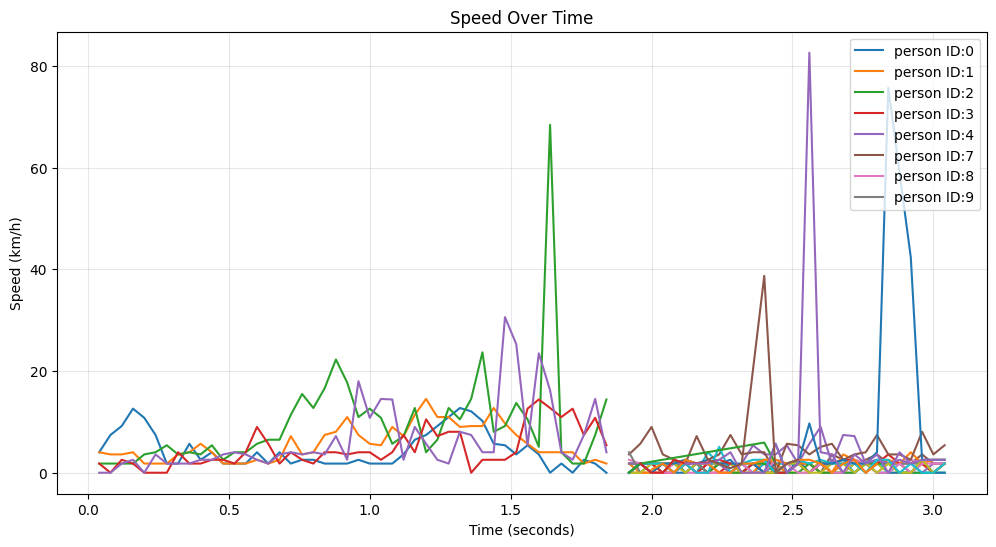

Calculating player statistics...
    distance_covered_m  avg_speed_kph  max_speed_kph  time_tracked_s
0                 2.24           2.70          12.73            1.80
1                 2.83           4.12          14.51            1.80
2                 4.85          11.45          68.40            1.80
3                 2.42           5.02          14.40            1.80
4                 3.32           5.52          30.60            1.80
7                 0.48           1.48           3.60            1.12
8                 0.23           0.71           2.55            1.12
9                 0.50           1.60           2.55            1.12
10                0.16           0.49           2.55            1.12
11                0.40           1.25           4.02            1.12
12                0.28           0.88           2.55            1.12
13                0.39           1.26           4.02            1.12
14                0.25           0.83           2.55            1.12
1

In [ ]:
if __name__ == "__main__":
    main()